In [1]:
import numpy as np
import scipy.signal
from scipy.io import wavfile
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt

from pandas import DataFrame

from scipy.signal.windows import hamming
from scipy.fft import fft

In [2]:
def initialize():
    path_hl = "NguyenAmHuanLuyen-16k"
    path_kt = "NguyenAmKiemThu-16k"
    folders_hl = [
        "23MTL", "24FTL", "25MLM", "27MCM", "28MVN", "29MHN", "30FTN",
        "32MTP", "33MHP", "34MQP", "35MMQ", "36MAQ", "37MDS", "38MDS",
        "39MTS", "40MHS", "41MVS", "42FQT", "43MNT", "44MTT", "45MDV"
    ]
    folders_kt = [
        "01MDA", "02FVA", "03MAB", "04MHB", "05MVB", "06FTB", "07FTC",
        "08MLD", "09MPD", "10MSD", "11MVD", "12FTD", "14FHH", "15MMH",
        "16FTH", "17MTH", "18MNK", "19MXK", "20MVK", "21MTL", "22MHL"
    ]

    files = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"]
    f_d = 0.025   # Duration of one frame (30 ms)
    f_s = 0.01   # Step size for frame shift (10 ms)
    N_FFTs = [512, 1024, 2048]    
    return path_hl, path_kt, folders_hl, folders_kt, files, f_d, f_s, N_FFTs

In [3]:
def calPerConMatrix(confusion_matrix):
    total_sum = 0
    num_samples = 21
    for i in range(5):
        # Calculate the accuracy percentage for each vowel
        percent = float(confusion_matrix[i + 1][i + 1]) / num_samples * 100
        confusion_matrix[i + 1][6] = percent
        total_sum += percent
    confusion_matrix[6][6] = total_sum / 5
    print(confusion_matrix)
    return confusion_matrix
# Example usage
# Initialize a confusion matrix with random values for demonstration
# In practice, replace this with the actual confusion matrix data
# cm_size = 6  # 5 classes + 1 column/row for percentages
# confusion_matrix_np = np.random.randint(0, 21, size=(cm_size, cm_size))
# # Calculate percentages
# confusion_matrix_np = calPerConMatrix(confusion_matrix_np)
# print(confusion_matrix_np)


In [4]:
def euclidean(v1, v2):

    # distance = np.sqrt(np.sum((v1 - v2) ** 2))

    distance = np.linalg.norm(v1 - v2)

    return distance

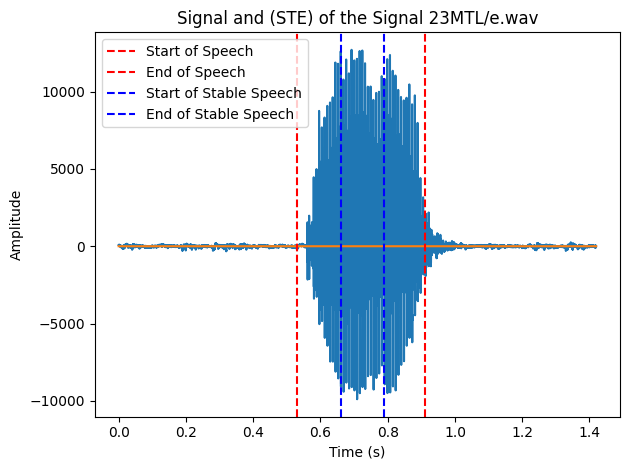

In [15]:
def process_signal(path, folder, file, f_d, f_s):
    # Construct the full path for the WAV file
    filepath = f"{path}/{folder}/{file}"

    # Read WAV file
    Fs, data = wavfile.read(filepath)
    T = 1 / Fs                          # Period
    n = len(data)                       # Number of samples in the signal
    t = n * T                           # Signal duration
    signal = data
    data = data / abs(max(data))        # Normalize amplitude to [-1, 1]
    # Number of samples in one frame (30ms)
    frame_len = round(f_d * Fs)
    # Number of samples to shift the frame (10ms)
    frame_shift_len = round(f_s * Fs)
    # Total number of frames
    n_f = int(np.floor((t - f_d) / f_s))
    # Split the data into frames
    frames = []
    index = 0
    for i in range(n_f):
        frame = data[index: index + frame_len]
        frames.append(frame)
        index += frame_shift_len
    frames = np.array(frames)
    # Calculate Short-Time Energy (STE) for each frame
    ste = np.sum(frames ** 2, axis=1)
    # Normalize STE to the range [0, 1]
    ste /= max(ste)
    # IDs containing speech frames
    id = np.where(ste >= 0.01)[0]
    # Calculate the length of the ID array
    len_id = len(id)
    distance = int(np.ceil((id[-1] - id[0]) / 3))
    frame_start = id[0] + distance
    frame_end = id[0] + 2 * distance
    t1 = np.arange(0, t, T)
    #t2 = np.arange(0, (n_f - 1) * f_s, f_s)


    #--------------------------------------------------------------------#
    # Uncomment the following line to plot the signal

    # Plotting the signal and the STE
    plt.figure()
    plt.plot(t1, signal) # Original signal
    plt.plot(t1, data)  # Normalize amplitude to [-1, 1]
    plt.title("Signal and (STE) of the Signal " + f"{folder}/{file}")

    plt.axvline(x=(id[0] - 1) * frame_shift_len * T, color='r', linestyle='--', label="Start of Speech")
    plt.axvline(x=(id[-1] - 1) * frame_shift_len * T, color='r', linestyle='--', label="End of Speech")
    plt.axvline(x=(frame_start - 1) * frame_shift_len * T, color='b', linestyle='--', label="Start of Stable Speech")
    plt.axvline(x=(frame_end - 1) * frame_shift_len * T, color='b', linestyle='--', label="End of Stable Speech")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return frames, frame_start, frame_end
# Example usage
frames, frame_start, frame_end = process_signal("NguyenAmHuanLuyen-16k", "23MTL", "e.wav", 0.03, 0.01)


In [6]:
def draw_result_matrix(result_matrix, title):
    # Draw table
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.axis('off')
    ax.axis('tight')
    ax.table(cellText=result_matrix, loc='center')
    fig.tight_layout()
    plt.show()

In [7]:
def draw_confusion_matrix(confusion_matrix, title):
    # Format the last column of the confusion matrix (percentages) to have 4 decimal places and keep NaNs as they are
    for row in confusion_matrix[1:]:
        if type(row[-1]) == float:  # Check if the value is a float before formatting to avoid formatting strings
            row[-1] = "{:.1f}".format(row[-1])
        else:
            row[-1] = ""  # If NaN or any non-float value, replace with empty string
    # Convert confusion_matrix to DataFrame for better handling of rows and column names
    df_cm = DataFrame(
        [row[1:] for row in confusion_matrix[1:]],  # Exclude the first column (labels)
        columns=confusion_matrix[0][1:],  # Use the first row for column names, excluding the first entry
        index=[row[0] for row in confusion_matrix[1:]]  # Use the first column for index labels
    )
    # Plotting using matplotlib
    fig, ax = plt.subplots(figsize=(14, 5))  # Adjust for an appropriate figure size
    ax.set_title(title)
    ax.axis('off')  # Hide axes
    tab = ax.table(cellText=df_cm.values, cellLoc='center', loc='center', rowLabels=df_cm.index, colLabels=df_cm.columns)
    tab.auto_set_font_size(False)
    tab.set_fontsize(14)
    tab.scale(1, 1.4)

    # Apply color formatting for maximum and minimum values
    max_index = df_cm.iloc[:-1, -1].astype(float).idxmax()  # Get the max percentage excluding the average
    min_index = df_cm.iloc[:-1, -1].astype(float).idxmin()  # Get the min percentage excluding the average

    for (i, row) in enumerate(df_cm.iterrows(), start=1):
        if row[0] == max_index :  # Highlight max accuracy row
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('lightgreen')
        if row[0] == min_index:  # Highlight min accuracy row
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('salmon')
    plt.show()


In [8]:
# def characteristic_vector_fft(frames, frame_start, frame_end, N_FFT):
#     # Assume frames is a NumPy 2D array with shape (number_of_frames, samples_per_frame)
#     w = hamming(frames.shape[1])
#     kernel = np.array([1/3, 1/3, 1/3])
#     frame_t = w * frames[frame_start-1]
#     # frame_v = w * frames[frame_start-1]  # -1 to convert from 1-based to 0-based indexing
#     frame_v = np.convolve(frame_t, kernel, mode='same')
#     X = np.abs(fft(frame_v, N_FFT))
#     # Accumulate the FFT spectra across the specified range of frames
#     for k in range(frame_start, frame_end):
#         frame1 = frames[k]
#         frame_t = w * frame1
#         frame_v = np.convolve(frame_t, kernel, mode='same')
#         # frame_v = w * frame1        
#         # Extract the FFT vector of a single signal frame
#         X = X + np.abs(fft(frame_v, N_FFT))
#     # Calculate the characteristic vector for a vowel of a speaker
#     vector = X / (frame_end - frame_start + 1)
#     return vector
# # Example usage:
# # Provide the frames, frame_start, frame_end and N_FFT parameters as needed.
# # The frames can be loaded or processed from audio using other Python functions.
# # The result will be a characteristic vector from the given frames.
def characteristic_vector_fft(frames, frame_start, frame_end, N_FFT):
    # Assume frames is a NumPy 2D array with shape (number_of_frames, samples_per_frame)
    w = hamming(frames.shape[1])
    frame_v = w * frames[frame_start-1]  # -1 to convert from 1-based to 0-based indexing
    X = np.abs(fft(frame_v, N_FFT))
    # Accumulate the FFT spectra across the specified range of frames
    for k in range(frame_start, frame_end):
        frame1 = frames[k]
        frame_v = w * frame1
        # Extract the FFT vector of a single signal frame
        X = X + np.abs(fft(frame_v, N_FFT))
    # Calculate the characteristic vector for a vowel of a speaker
    vector = X / (frame_end - frame_start + 1)
    return vector
# Example usage:
# Provide the frames, frame_start, frame_end and N_FFT parameters as needed.
# The frames can be loaded or processed from audio using other Python functions.
# The result will be a characteristic vector from the given frames.



In [9]:
def draw_character_vector_fft(files, vectors, n_fft, title):
    Fs = 16000
    freq = np.linspace(0, Fs/2, int(n_fft/2))
    plt.figure(figsize=(10, 5))
    plt.plot(freq, vectors[0, :int(n_fft/2)], 'r', label=files[0])
    plt.plot(freq, vectors[1, :int(n_fft/2)], 'g', label=files[1])
    plt.plot(freq, vectors[2, :int(n_fft/2)], 'b', label=files[2])
    plt.plot(freq, vectors[3, :int(n_fft/2)], 'y', label=files[3])
    plt.plot(freq, vectors[4, :int(n_fft/2)], 'k', label=files[4])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('FFT Magnitude')
    plt.legend()
    plt.show()
# Example usage
# files = ["file1.wav", "file2.wav", "file3.wav", "file4.wav", "file5.wav"]
# vectors = np.random.rand(5, 8000)  # Replace with actual vectors
# n_fft = 16000
# title1 = "Character Vectors FFT"
# draw_character_vector_fft(files, vectors, n_fft, title1)


In [10]:
def training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT):
    vectors = np.zeros((5, N_FFT))  # Assuming vectors is a 2D array of 5 rows and N_FFT columns
    # Loop through each vowel to calculate its characteristic vector
    for i in range(5):  # Python is zero-indexed while MATLAB is 1-indexed
        X = None
        for j in range(21):
            # Mark the region with stable spectral features characteristic of the vowel
            frames, frame_start, frame_end = process_signal(path_hl, folders_hl[j], files[i], f_d, f_s)
            # Calculate the characteristic vector of a vowel from 21 speakers
            if j == 0:  # Use zero-based indexing
                X = characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
            else:
                X += characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
        # Calculate the average characteristic vector for a vowel from 21 speakers
        vectors[i, :] = X / 21
    return vectors
# Example usage (given the necessary functions were properly implemented in Python):
# path_hl = "path/to/high/level/folder"
# folders_hl = ["folder1", "folder2", "folder3", "folder4", "folder5"]
# files = ["file1", "file2", "file3", "file4", "file5"]
# f_d = 0.025
# f_s = 0.01
# N_FFT = 256
# vectors = training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT)


In [11]:
def testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors):
    num_folders = len(folders_kt)
    num_files = len(files)

    result = np.zeros((num_folders + 1, num_files + 1), dtype=object)
    result[0, 0] = ""
    result[1:, 0] = folders_kt
    result[0, 1:] = files

    confusion_matrix = [
        ["", "a", "e", "i", "o", "u", "Độ chính xác (%)"],
        ["a", 0, 0, 0, 0, 0, 0],
        ["e", 0, 0, 0, 0, 0, 0],
        ["i", 0, 0, 0, 0, 0, 0],
        ["o", 0, 0, 0, 0, 0, 0],
        ["u", 0, 0, 0, 0, 0, 0],
        ["Độ chính xác trung bình (%)", "", "", "", "", "", 0]
    ]

    vowels = ["a", "e", "i", "o", "u"]
    for i in range(num_folders):
        for j in range(num_files):
            # Mark the region with stable spectral features characteristic of the vowel
            frames, frame_start, frame_end = process_signal(path_kt, folders_kt[i], files[j], f_d, f_s)
            # Calculate the characteristic vector of a vowel from 21 speakers
            vector = characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
            # Calculate the Euclidean distance between the test vector and the training vectors
            min_dist = euclidean(vectors[0, :], vector)
            index = 0
            for k in range(1, 5):
                min_t = euclidean(vectors[k, :], vector)
                if min_t < min_dist:
                    min_dist = min_t
                    index = k
            # Update the result matrix & confusion matrix
            result[i + 1, j + 1] = vowels[index]
            confusion_matrix[j + 1][index + 1] += 1
    # Update the accuracy percentage on the confusion matrix if needed
    # ...
    # print(result)
    print(confusion_matrix)
    return result, confusion_matrix
# Definitions for the undefined functions in this code should be added or modified accordingly.
# Example usage:
# confusion_matrix = testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors)


In [12]:
def Bai2(path_hl, path_kt, folders_hl, folders_kt, files, N_FFTs, f_d, f_s):
    for N_FFT in N_FFTs:
        vectors = training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT)
        title = f"Vector đặc trưng FFT với N_FFT = {N_FFT}"
        draw_character_vector_fft(files, vectors, N_FFT, title)
        # Perform testing and obtain confusion matrix
        result, confusion_matrix = testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors)
        # Calculate the percentage of correct and incorrect recognitions
        confusion_matrix = calPerConMatrix(confusion_matrix)
        # Draw the result matrix & confusion matrix
        title1 = f"Result matrix with N_FFT = {N_FFT}"
        draw_result_matrix(result, title1)
        title2 = f"Confusion matrix with N_FFT = {N_FFT}"
        draw_confusion_matrix(confusion_matrix, title2)


C:\Users\Quang Dong\AppData\Local\Temp\ipykernel_18140\3073746695.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


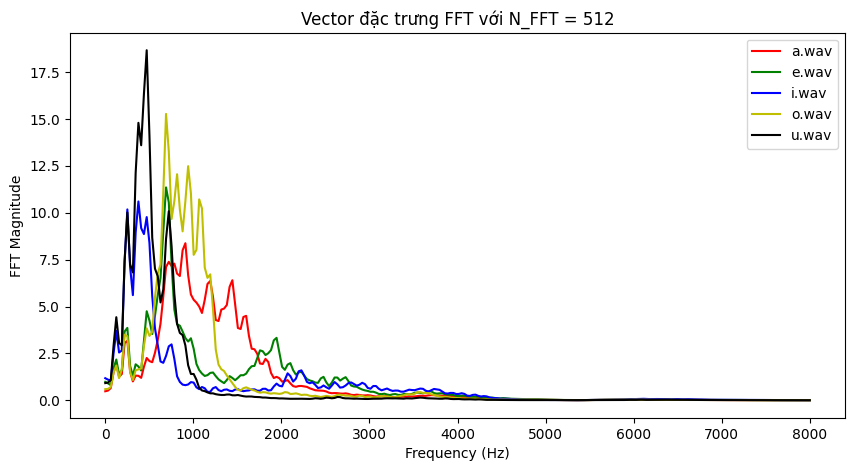

[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 0], ['e', 1, 18, 0, 2, 0, 0], ['i', 0, 0, 13, 0, 8, 0], ['o', 1, 1, 0, 18, 1, 0], ['u', 0, 1, 3, 0, 17, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 85.71428571428571], ['e', 1, 18, 0, 2, 0, 85.71428571428571], ['i', 0, 0, 13, 0, 8, 61.904761904761905], ['o', 1, 1, 0, 18, 1, 85.71428571428571], ['u', 0, 1, 3, 0, 17, 80.95238095238095], ['Độ chính xác trung bình (%)', '', '', '', '', '', 80.0]]


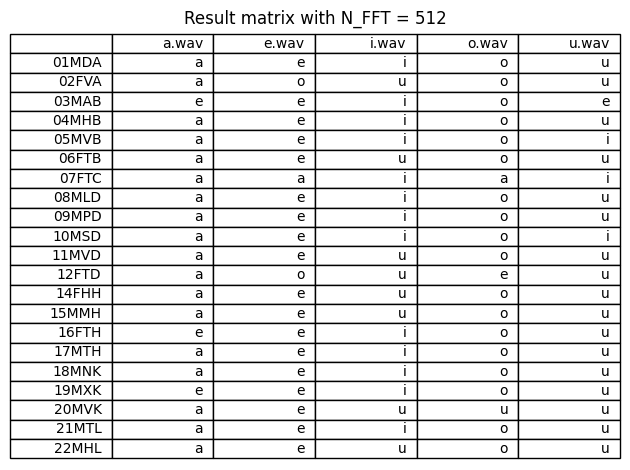

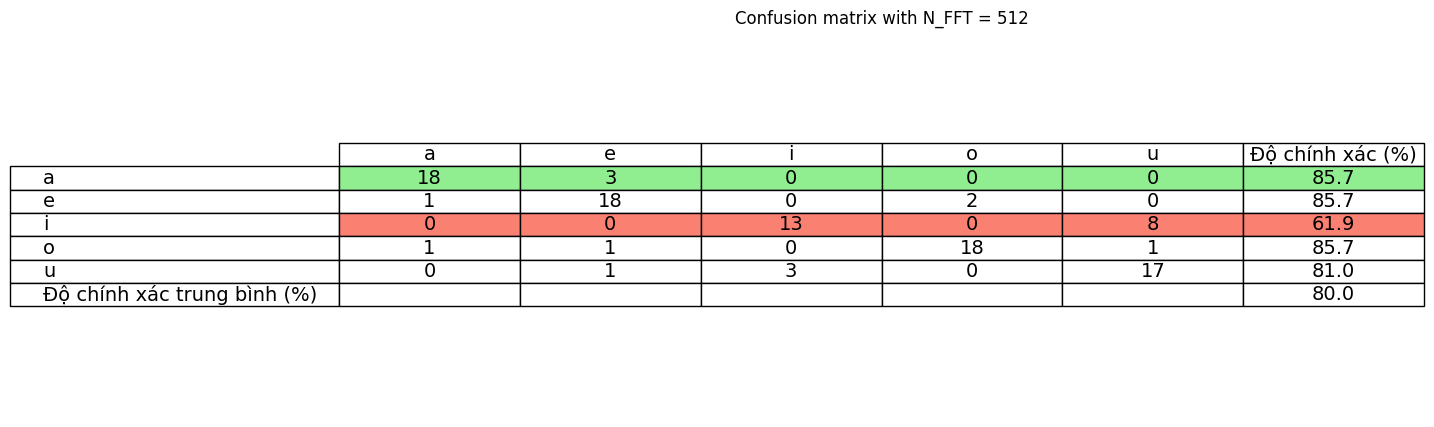

C:\Users\Quang Dong\AppData\Local\Temp\ipykernel_18140\3073746695.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


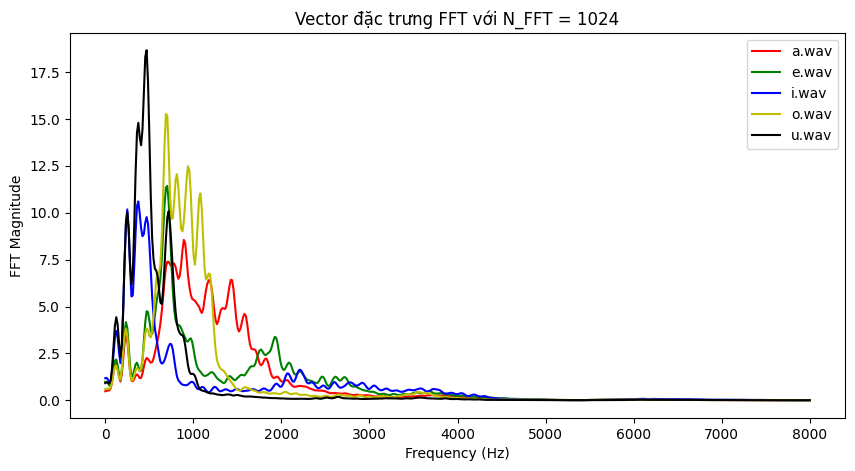

[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 0], ['e', 1, 18, 0, 2, 0, 0], ['i', 0, 0, 13, 0, 8, 0], ['o', 1, 1, 0, 18, 1, 0], ['u', 0, 1, 3, 0, 17, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 85.71428571428571], ['e', 1, 18, 0, 2, 0, 85.71428571428571], ['i', 0, 0, 13, 0, 8, 61.904761904761905], ['o', 1, 1, 0, 18, 1, 85.71428571428571], ['u', 0, 1, 3, 0, 17, 80.95238095238095], ['Độ chính xác trung bình (%)', '', '', '', '', '', 80.0]]


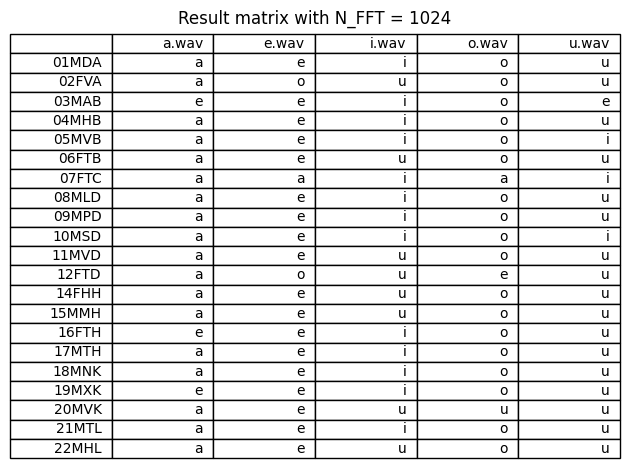

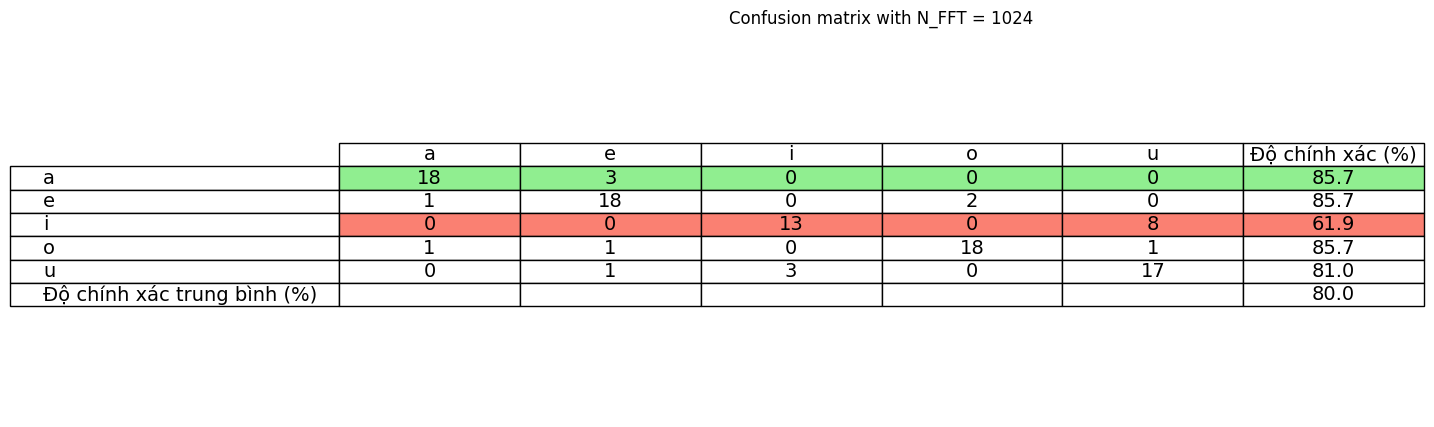

C:\Users\Quang Dong\AppData\Local\Temp\ipykernel_18140\3073746695.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


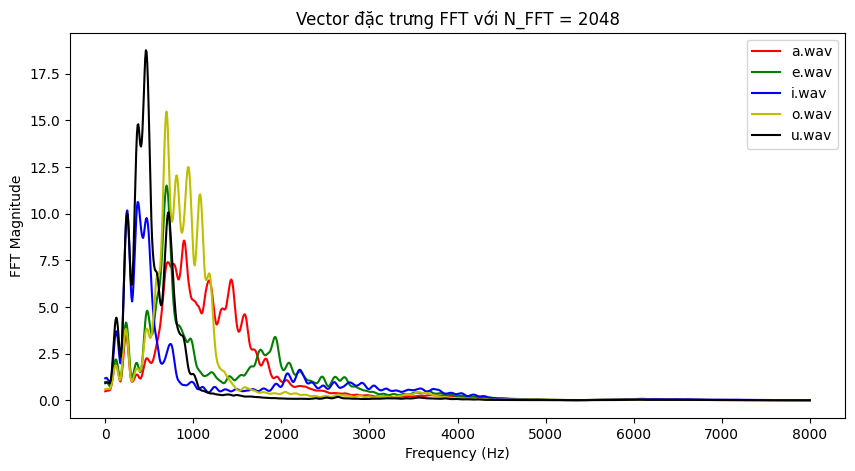

[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 0], ['e', 1, 18, 0, 2, 0, 0], ['i', 0, 0, 13, 0, 8, 0], ['o', 1, 1, 0, 18, 1, 0], ['u', 0, 1, 3, 0, 17, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 18, 3, 0, 0, 0, 85.71428571428571], ['e', 1, 18, 0, 2, 0, 85.71428571428571], ['i', 0, 0, 13, 0, 8, 61.904761904761905], ['o', 1, 1, 0, 18, 1, 85.71428571428571], ['u', 0, 1, 3, 0, 17, 80.95238095238095], ['Độ chính xác trung bình (%)', '', '', '', '', '', 80.0]]


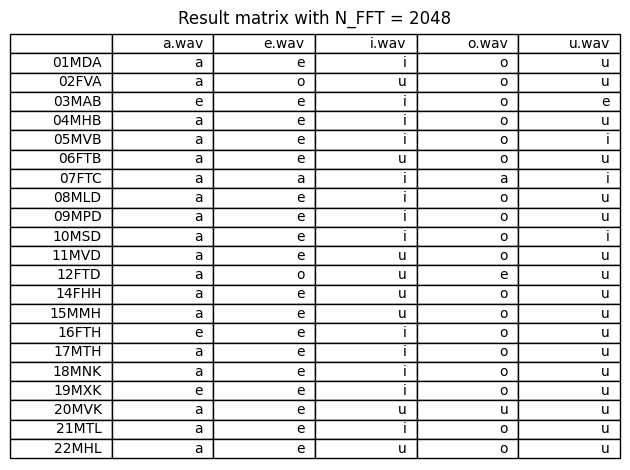

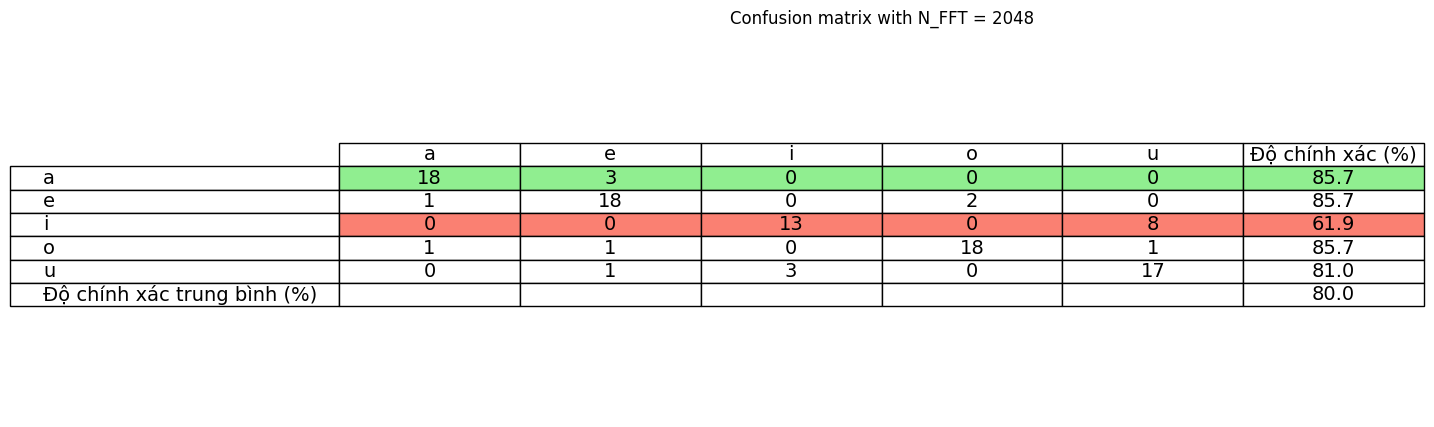

In [13]:
#initialize
path_hl, path_kt, folders_hl, folders_kt, files, f_d, f_s, N_FFTs = initialize()
#Bai2
Bai2(path_hl, path_kt, folders_hl, folders_kt, files, N_FFTs, f_d, f_s)